In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import torch as th

Global seed set to 0


# Read and plot data

In [2]:
adata =  sc.read('../../scEUseq_organoids/scEU_organoid.h5ad')
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
 }

adata.obs['celltype'] = adata.obs.som_cluster_id.map(cell_mapper).astype('str')
adata.obs['clusters'] = adata.obs['celltype']
adata.layers['spliced'] = adata.layers['su']  + adata.layers['sl']
adata.layers['unspliced'] = adata.layers['uu'] + adata.layers['ul']

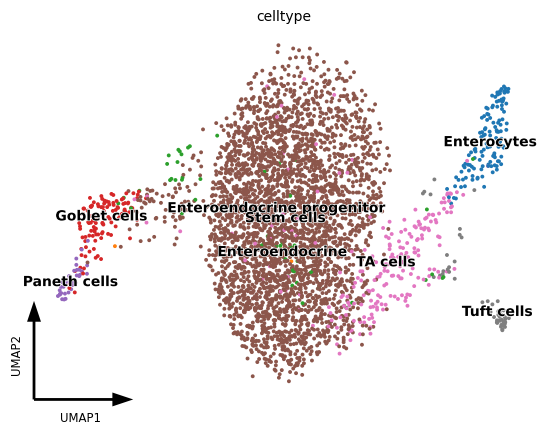

In [3]:
scv.pl.umap(adata, color='celltype', frameon='artist')

# Fit annotated LatentVelo

We fit the model for a seed known to be reversed.

In [4]:
th.manual_seed(521)


scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.anvi_clean_recipe(adata, n_top_genes=2000, celltype_key='celltype')

model = ltv.models.AnnotVAE(observed=2000, latent_dim=40, encoder_hidden=45, zr_dim=2, h_dim=3,
                      celltypes=len(adata.obs['celltype'].unique())) # 20, 25

epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 250,
                                      epochs=50, name='organoid_parameters', grad_clip=100, random_seed=521)

Filtered out 3076 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:11) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Warning, folder already exists. This may overwrite a previous fit.
353 velocity genes used
epoch 0, full loss 369.902, val loss 155.896, ae MSE 0.940, traj MSE 0.445, reg loss -2.392
epoch 1, full loss 251.611, val loss 112.587, ae MSE 0.812, traj MSE 0.246, reg loss -3.028
epoch 2, full loss 136.541, val loss 85.481, ae MSE 0.660, traj MSE 0.227, reg loss -3.431
epoch 3, full loss 93.306, val loss 51.708, ae MSE 0.495, traj MSE 0.219, reg loss -3.794
epoch 4, full loss 109.156, val loss 17.168, ae MSE 0.411, traj MSE 0.215, reg loss -4.165
epoch 5, full loss 65.737, val loss -14.692, ae MSE 0.356, traj MSE 0.214, re

computing velocity graph (using 1/16 cores)


  0%|          | 0/3831 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


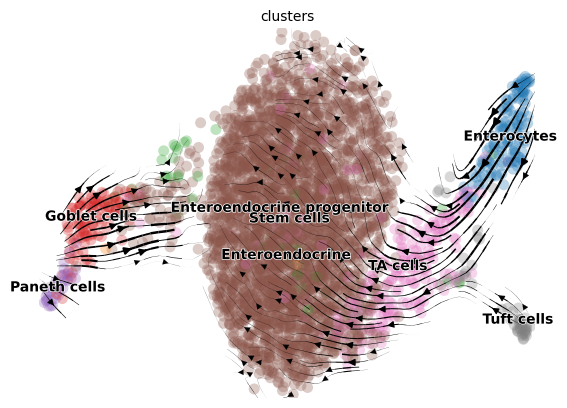

In [5]:
latent_adata = ltv.output_results(model, adata)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, color='clusters', vkey='spliced_velocity')

# Re-train model with root cells specified

Velocities are reversed. We can re-train the model with the stem cells set as the root cells.

In [6]:
adata =  sc.read('../../scEUseq_organoids/scEU_organoid.h5ad')
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
 }

adata.obs['celltype'] = adata.obs.som_cluster_id.map(cell_mapper).astype('str')
adata.obs['clusters'] = adata.obs['celltype']
adata.layers['spliced'] = adata.layers['su']  + adata.layers['sl']
adata.layers['unspliced'] = adata.layers['uu'] + adata.layers['ul']

th.manual_seed(521)

scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.anvi_clean_recipe(adata, n_top_genes=2000, celltype_key='celltype', root_cells='Stem cells')

model = ltv.models.AnnotVAE(observed=2000, latent_dim=40, encoder_hidden=45, zr_dim=2, h_dim=3,
                            celltypes=len(adata.obs['celltype'].unique()), root_weight=1e6, time_reg_decay=15)

epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 250,
                                      epochs=50, name='organoid_parameters', grad_clip=100, random_seed=521)

Filtered out 3076 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Warning, folder already exists. This may overwrite a previous fit.
353 velocity genes used
epoch 0, full loss 5299.334, val loss 33903.680, ae MSE 2.099, traj MSE 1.351, reg loss -2.954
epoch 1, full loss 1763.179, val loss 123.164, ae MSE 1.019, traj MSE 0.614, reg loss -3.564
epoch 2, full loss 1291.936, val loss 93.283, ae MSE 0.849, traj MSE 0.573, reg loss -3.476
epoch 3, full loss 1521.261, val loss 60.178, ae MSE 0.708, traj MSE 0.538, reg loss -2.662
epoch 4, full loss 1629.030, val loss 27.256, ae MSE 0.616, traj MSE 0.399, reg loss -2.591
epoch 5, full loss 1661.033, val loss -4.197, ae MSE 0.556, traj MSE 

computing velocity graph (using 1/16 cores)


  0%|          | 0/3831 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


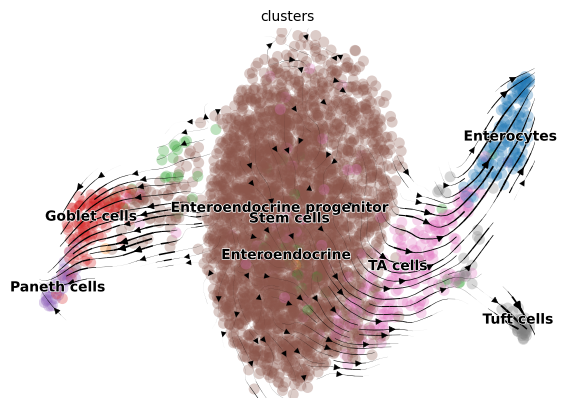

In [7]:
latent_adata = ltv.output_results(model, adata)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, color='clusters', vkey='spliced_velocity')